In [1]:
import numpy as np
import pandas as pd

In [2]:
path = r"D:\helloiitk sem summer\EE798Q\STOCK_INDEX.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2689,2021-04-26,14449.45020,14557.50000,14421.29981,14485.00000,14485.00000,452700.0
2690,2021-04-27,14493.79981,14667.54981,14484.84961,14653.04981,14653.04981,451800.0
2691,2021-04-28,14710.50000,14890.25000,14694.95020,14864.54981,14864.54981,457000.0
2692,2021-04-29,14979.00000,15044.34961,14814.45020,14894.90039,14894.90039,517500.0
2693,2021-04-30,14747.34961,14855.45020,14601.70020,14631.09961,14631.09961,613900.0


In [5]:
df.isnull().sum()

Date          0
Open         27
High         27
Low          27
Close        27
Adj Close    27
Volume       27
dtype: int64

In [6]:
df2 = df.drop(df.columns[0], axis=1)
df2

,Open,High,Low,Close,Adj Close,Volume
0,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...
2689,14449.450200,14557.500000,14421.299810,14485.000000,14485.000000,452700.0
2690,14493.799810,14667.549810,14484.849610,14653.049810,14653.049810,451800.0
2691,14710.500000,14890.250000,14694.950200,14864.549810,14864.549810,457000.0
2692,14979.000000,15044.349610,14814.450200,14894.900390,14894.900390,517500.0


In [7]:
from sklearn.impute import SimpleImputer

# Interpolate missing values using linear interpolation
df_interpolated = df2.interpolate(method='linear')

# Use SimpleImputer to handle any remaining missing values
imputer = SimpleImputer(strategy='mean')
ndf = pd.DataFrame(imputer.fit_transform(df_interpolated), columns=df_interpolated.columns)


In [8]:
df1 = ndf.reset_index()['Close']

In [9]:
df1.shape

(2694,)

In [10]:
df1

0        5232.200195
1        5277.899902
2        5281.799805
3        5263.100098
4        5244.750000
            ...     
2689    14485.000000
2690    14653.049810
2691    14864.549810
2692    14894.900390
2693    14631.099610
Name: Close, Length: 2694, dtype: float64

In [11]:
df1.isnull().sum()

0

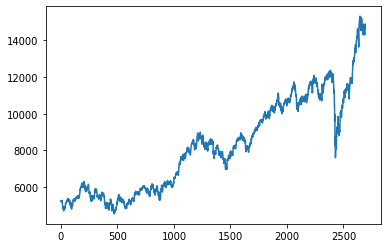

In [12]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [13]:
### LSTM are sensitive to the scale of the data, so we apply MinMax scaler

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
df1.shape

(2694, 1)

In [16]:
df1

array([[0.06387819],
       [0.06812123],
       [0.06848332],
       ...,
       [0.95820525],
       [0.96102318],
       [0.93653028]])

In [17]:
### splitting dataset into train and test split
training_size = int(len(df1)*0.8)
test_size = len(df1) - training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]
type(test_data)

numpy.ndarray

In [18]:
training_size,test_size

(2155, 539)

In [19]:
def create_dataset(dataset,time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [20]:
### reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
len(X_train[0])

50

In [21]:
# reshape input to be [samples, times steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
### Create the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1] , 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

model1 = Sequential()
model1.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model1.add(GRU(50, return_sequences=True))
model1.add(GRU(50))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

model1.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 50, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 38,601
Trainable params: 38,601
Non-trainable params: 0
_________________________________________________________________


In [26]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100,batch_size=64,verbose=1)

Epoch 1/100
33/33 [==============================] - 6s 75ms/step - loss: 0.0152 - val_loss: 8.9311e-04
Epoch 2/100
33/33 [==============================] - 2s 49ms/step - loss: 3.3607e-04 - val_loss: 9.0840e-04
Epoch 3/100
33/33 [==============================] - 2s 50ms/step - loss: 1.4729e-04 - val_loss: 8.4984e-04
Epoch 4/100
33/33 [==============================] - 2s 51ms/step - loss: 1.3274e-04 - val_loss: 8.0044e-04
Epoch 5/100
33/33 [==============================] - 2s 51ms/step - loss: 1.2754e-04 - val_loss: 7.3247e-04
Epoch 6/100
33/33 [==============================] - 2s 53ms/step - loss: 1.2308e-04 - val_loss: 6.8476e-04
Epoch 7/100
33/33 [==============================] - 2s 51ms/step - loss: 1.2492e-04 - val_loss: 6.7635e-04
Epoch 8/100
33/33 [==============================] - 2s 50ms/step - loss: 1.1772e-04 - val_loss: 6.4880e-04
Epoch 9/100
33/33 [==============================] - 2s 49ms/step - loss: 1.1509e-04 - val_loss: 5.7634e-04
Epoch 10/100
33/33 [============

33/33 [==============================] - 2s 54ms/step - loss: 4.5570e-05 - val_loss: 2.7106e-04
Epoch 77/100
33/33 [==============================] - 2s 55ms/step - loss: 4.7886e-05 - val_loss: 3.1652e-04
Epoch 78/100
33/33 [==============================] - 2s 54ms/step - loss: 4.6582e-05 - val_loss: 3.8553e-04
Epoch 79/100
33/33 [==============================] - 2s 54ms/step - loss: 5.1661e-05 - val_loss: 3.0764e-04
Epoch 80/100
33/33 [==============================] - 2s 55ms/step - loss: 4.7101e-05 - val_loss: 3.3569e-04
Epoch 81/100
33/33 [==============================] - 2s 54ms/step - loss: 4.4389e-05 - val_loss: 2.8493e-04
Epoch 82/100
33/33 [==============================] - 2s 55ms/step - loss: 4.7748e-05 - val_loss: 3.3270e-04
Epoch 83/100
33/33 [==============================] - 2s 55ms/step - loss: 5.1620e-05 - val_loss: 3.1058e-04
Epoch 84/100
33/33 [==============================] - 2s 55ms/step - loss: 4.3617e-05 - val_loss: 2.6401e-04
Epoch 85/100
33/33 [============

In [27]:
model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=100,batch_size=64,verbose=1)

Epoch 1/100
33/33 [==============================] - 7s 96ms/step - loss: 0.0119 - val_loss: 0.0083
Epoch 2/100
33/33 [==============================] - 2s 69ms/step - loss: 5.9120e-04 - val_loss: 0.0030
Epoch 3/100
33/33 [==============================] - 2s 71ms/step - loss: 3.9258e-04 - val_loss: 0.0028
Epoch 4/100
33/33 [==============================] - 2s 70ms/step - loss: 3.7870e-04 - val_loss: 0.0032
Epoch 5/100
33/33 [==============================] - 2s 70ms/step - loss: 3.7191e-04 - val_loss: 0.0028
Epoch 6/100
33/33 [==============================] - 2s 70ms/step - loss: 3.6640e-04 - val_loss: 0.0025
Epoch 7/100
33/33 [==============================] - 2s 69ms/step - loss: 3.5602e-04 - val_loss: 0.0025
Epoch 8/100
33/33 [==============================] - 2s 69ms/step - loss: 3.4207e-04 - val_loss: 0.0027
Epoch 9/100
33/33 [==============================] - 2s 70ms/step - loss: 3.3957e-04 - val_loss: 0.0022
Epoch 10/100
33/33 [==============================] - 2s 70ms/step -

33/33 [==============================] - 2s 68ms/step - loss: 7.8516e-05 - val_loss: 2.9888e-04
Epoch 78/100
33/33 [==============================] - 2s 68ms/step - loss: 8.3070e-05 - val_loss: 5.4735e-04
Epoch 79/100
33/33 [==============================] - 2s 69ms/step - loss: 6.3984e-05 - val_loss: 3.4746e-04
Epoch 80/100
33/33 [==============================] - 2s 68ms/step - loss: 5.9843e-05 - val_loss: 3.5140e-04
Epoch 81/100
33/33 [==============================] - 2s 69ms/step - loss: 6.4440e-05 - val_loss: 4.7653e-04
Epoch 82/100
33/33 [==============================] - 2s 71ms/step - loss: 6.0049e-05 - val_loss: 2.8794e-04
Epoch 83/100
33/33 [==============================] - 2s 68ms/step - loss: 5.9587e-05 - val_loss: 2.7616e-04
Epoch 84/100
33/33 [==============================] - 2s 68ms/step - loss: 5.7761e-05 - val_loss: 2.8096e-04
Epoch 85/100
33/33 [==============================] - 2s 69ms/step - loss: 6.0563e-05 - val_loss: 2.7953e-04
Epoch 86/100
33/33 [============

In [28]:
import tensorflow as tf

In [29]:
tf.__version__

'2.9.1'

In [54]:
from keras.models import load_model

# Assuming you have a trained model called 'model'
model.save('lstm_model.h5')


In [55]:
model1.save('gru_model.h5')

In [57]:
model = load_model('gru_model.h5')

In [58]:
### Let's do prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 0s 12ms/step


In [59]:
### Transform back to originalform
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [60]:
### Calculate RMSE performance metrics
import math
import sklearn
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
# 7706.4050090478995

7658.3566635546

In [61]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))
# 11907.724656986786

11918.651568274785

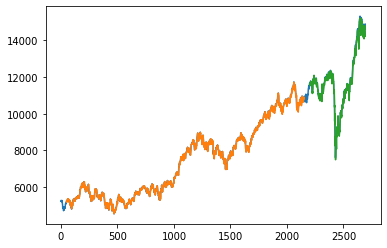

In [62]:
### Plotting 
# shift train predictions for plotting
import numpy
look_back = 50
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [63]:
x_input = test_data[len(test_data)-look_back:].reshape(1,-1)
x_input.shape

(1, 50)

In [64]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [65]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=look_back
i=0
while(i<2):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

1 day input [0.98594305 1.         0.99988394 0.99017689 0.98182536 0.9436516
 0.96911005 0.97981982 0.92706469 0.94864209 0.96326999 0.99358427
 0.97827861 0.96503407 0.96671464 0.97991738 0.98701078 0.97365489
 0.96423563 0.96246692 0.94490503 0.9297293  0.94701265 0.94630706
 0.95358152 0.92894482 0.90810085 0.92503594 0.95639937 0.94206397
 0.9584652  0.93715237 0.94139546 0.95398074 0.95906407 0.9554477
 0.90679166 0.92480383 0.93192052 0.93530007 0.91130867 0.90545473
 0.9156446  0.9096281  0.92296549 0.93856828 0.95820525 0.96102318
 0.93653028 0.92011517]
1 day output [[0.9075772]]
[[0.9201151728630066], [0.9075772166252136]]


In [66]:
day_new = np.arange(1,look_back+1)
day_pred = np.arange(look_back+1,look_back+3)

In [67]:
import matplotlib.pyplot as plt

In [68]:
len(df1)

2694

In [69]:
df3 = df1.tolist()
df3.extend(lst_output)

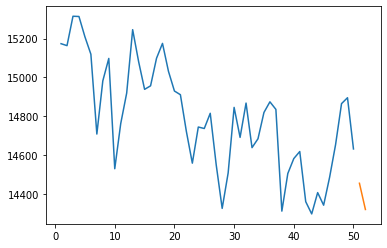

In [70]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-look_back:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [71]:
df3=scaler.inverse_transform(df3).tolist()

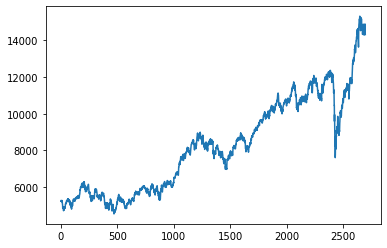

In [72]:
plt.plot(df3)

In [73]:
df3[-1]
# 13928.127078225842

[14319.260611199748]

In [74]:
df3[-2]
# 14289.528328010954

[14454.300668921587]

In [75]:
df3[-3]

[14631.09961]

In [76]:
df3[-4]

[14894.90039]

In [77]:
df3[-5]

[14864.54981]

In [78]:
df3[-6]

[14653.049809999999]

In [79]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2689,2021-04-26,14449.45020,14557.50000,14421.29981,14485.00000,14485.00000,452700.0
2690,2021-04-27,14493.79981,14667.54981,14484.84961,14653.04981,14653.04981,451800.0
2691,2021-04-28,14710.50000,14890.25000,14694.95020,14864.54981,14864.54981,457000.0
2692,2021-04-29,14979.00000,15044.34961,14814.45020,14894.90039,14894.90039,517500.0
2693,2021-04-30,14747.34961,14855.45020,14601.70020,14631.09961,14631.09961,613900.0
